In [0]:
from scipy.stats import mode
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from PIL import Image
import os
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

In [0]:
# Custom activation function for ANN
def custom_relu(x):
    return tf.maximum(0.0, x)


# Custom metric for evaluation
def custom_accuracy(y_true, y_pred):
    correct_predictions = tf.equal(y_true, y_pred)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


# ANN Classifier Class
def custom_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * tf.math.log(y_pred))

In [43]:
class ANNClassifier:
    def __init__(self, input_shape, num_classes, hidden_layers_sizes=(64, 32)):
        self.model = Sequential()
        self.model.add(Flatten(input_shape=input_shape))
        for size in hidden_layers_sizes:
            self.model.add(Dense(size, activation=custom_relu))
        self.model.add(Dense(num_classes, activation='softmax'))

    def compile(self, optimizer):
        self.model.compile(optimizer=optimizer, loss=custom_loss)

    def fit(self, X, y, epochs=10, batch_size=32):
        self.history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size)
        return self.history

    def predict(self, X):
        return self.model.predict(X)


# GMM Classifier Class
class GMMClassifier:
    def __init__(self, n_components):
        self.gmm = GaussianMixture(n_components=n_components)

    def fit(self, X):
        self.gmm.fit(X)

    def predict(self, X):
        return self.gmm.predict(X)


# Ensemble Class
class Ensemble:
    def __init__(self, ann, gmm):
        self.ann = ann
        self.gmm = gmm

    def fit(self, X, y):
        # Fit ANN
        history = self.ann.fit(X, y)
        # Get ANN predictions to use as features for GMM
        ann_predictions = self.ann.predict(X)
        print(ann_predictions.shape)
        # Fit GMM with features from ANN
        self.gmm.fit(ann_predictions)
        return history

    def predict(self, X):
        # Get ANN predictions to use as features for GMM
        ann_predictions = self.ann.predict(X)
        # Predict with GMM
        return self.gmm.predict(ann_predictions)


# Function to load images and preprocess them
def load_images(image_paths, target_size=(32, 32)):
    images = []
    labels = []
    for image_path in image_paths:
        # Load image
        img = Image.open(image_path).convert('RGB')  # Convert to RGB format
        img = img.resize(target_size)  # Resize image to target size
        img_array = np.array(img)  # Convert to numpy array
        images.append(img_array)
        # Extract label from file path
        label = os.path.basename(os.path.dirname(image_path))
        labels.append(label)
    images = np.array(images, dtype='float32') / 255.0  # Normalize pixel values
    # Convert labels to integer encoding
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = tf.keras.utils.to_categorical(labels)  # Convert labels to one-hot encoding
    return images, labels


# 重新映射聚类标签以匹配真实标签
def remap_labels(true_labels, predicted_labels):
    unique_true_labels = np.unique(true_labels)
    mapped_labels = np.zeros_like(predicted_labels)
    for true_label in unique_true_labels:
        mask = (true_labels == true_label)
        # Find the cluster label that most frequently occurs with this true label
        most_common = mode(predicted_labels[mask])[0][0]
        mapped_labels[predicted_labels == most_common] = true_label
    return mapped_labels


# 可视化训练历史
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

In [44]:
# Load images
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths)

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/10


2023-12-03 17:14:26.890695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 13ms/step - loss: 0.0962
Epoch 2/10
14/14 [==============================] - 0s 6ms/step - loss: 0.0604
Epoch 3/10
14/14 [==============================] - 0s 6ms/step - loss: 0.0325
Epoch 4/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0144
Epoch 5/10
14/14 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 6/10
14/14 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 7/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 8/10
14/14 [==============================] - 0s 7ms/step - loss: 8.8542e-04
Epoch 9/10
14/14 [==============================] - 0s 6ms/step - loss: 6.6923e-04
Epoch 10/10
14/14 [==============================] - 0s 3ms/step
(435, 32)


2023-12-03 17:14:28.140413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 9ms/step


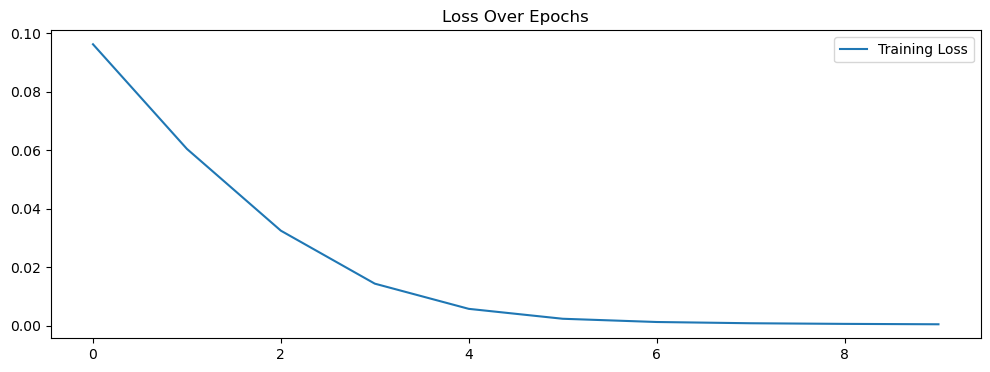

In [45]:
# Define the ANN and GMM models
ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1])
ann.compile(optimizer=tf.keras.optimizers.Adam())
gmm = GMMClassifier(n_components=y_train.shape[1])

# Create the ensemble model
ensemble = Ensemble(ann, gmm)

# Fit the ensemble model
history = ensemble.fit(X_train, y_train)

# Predict with the ensemble model
y_pred = ensemble.predict(X_test)
y_test = np.argmax(y_test, axis=1)
plot_history(history)

Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]


/var/folders/fm/_6wfn0r96gjcpy7779d0j2fc0000gn/T/ipykernel_43885/3089739837.py:116: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common = mode(predicted_labels[mask])[0][0]


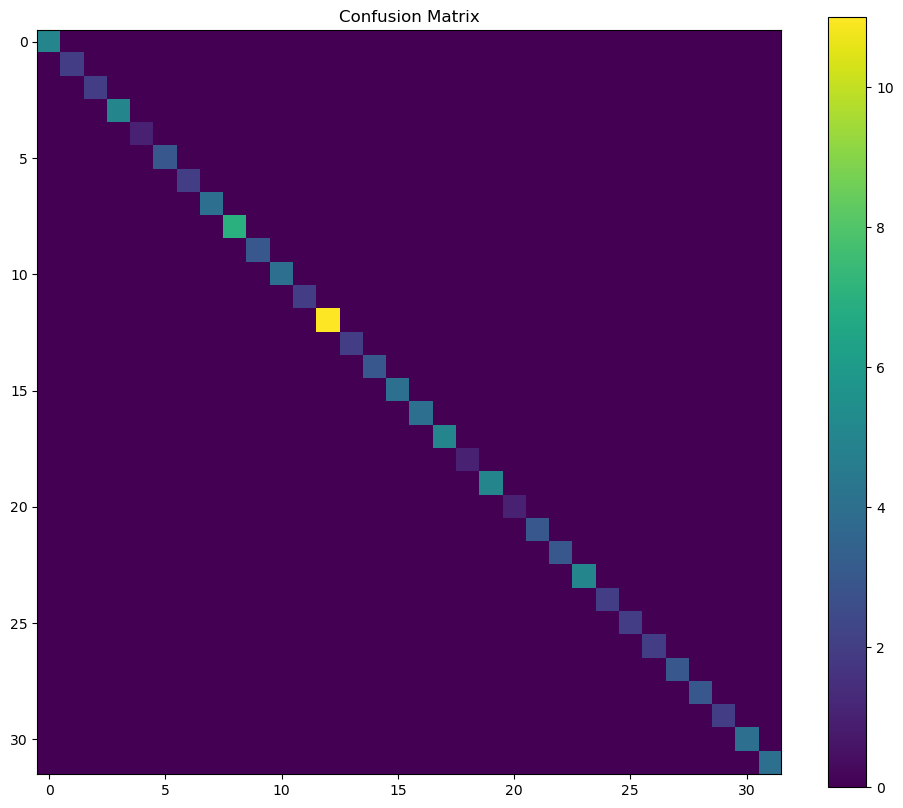

In [46]:
mapped_predictions = remap_labels(y_test, y_pred)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, mapped_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

In [47]:
# Calculate custom accuracy
test_accuracy = custom_accuracy(y_test, mapped_predictions)

# 输出分类报告
print('Classification Report:')
print(classification_report(y_test, mapped_predictions))

# Print the custom accuracy
print('Test accuracy:', test_accuracy.numpy())

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         4
    

4/4 [==============================] - 0s 2ms/step


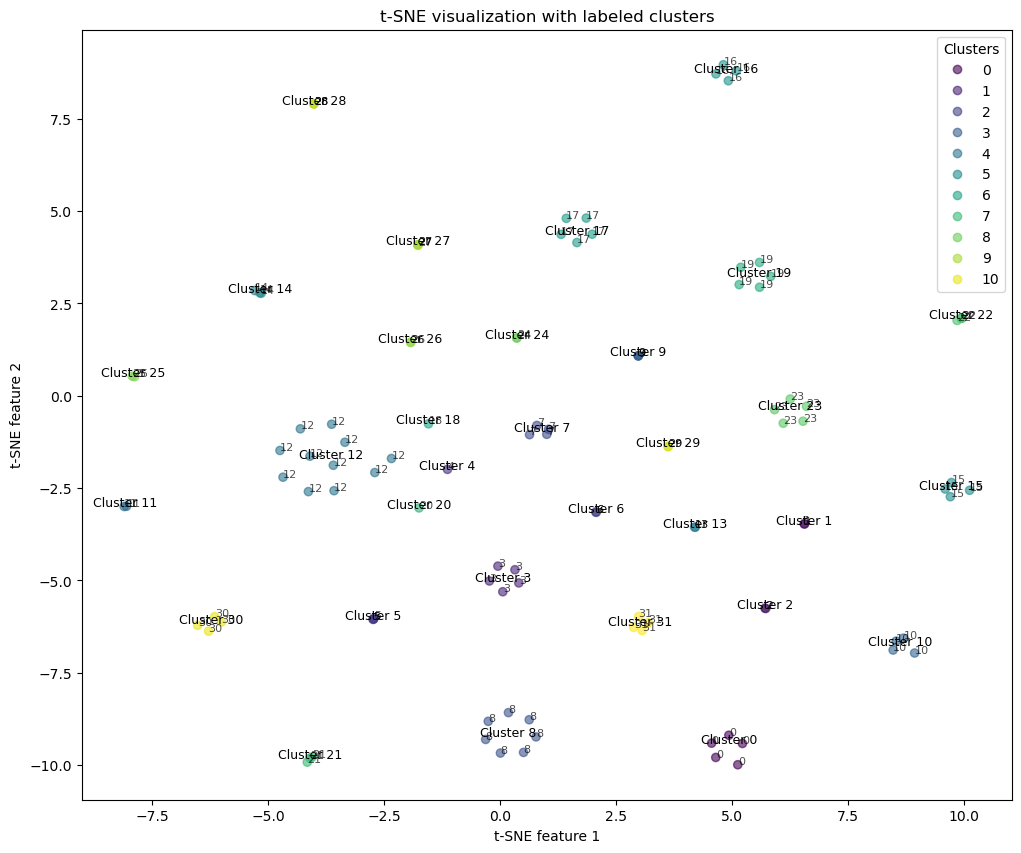

In [48]:
def visualize_clusters_with_labels(X, y, model):
    # 通过神经网络模型提取特征
    features = model.predict(X)

    # 使用t-SNE降维到二维
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_reduced = tsne.fit_transform(features)

    # 绘制所有聚类的散点图
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.6)

    # 为每个聚类的质心添加注释
    # 如果聚类数量很多，这可能会导致图表拥挤
    unique_labels = np.unique(y)
    for i, label in enumerate(unique_labels):
        xtext, ytext = np.median(X_reduced[y == label, :], axis=0)
        txt = f'Cluster {label}'
        plt.annotate(txt, (xtext, ytext), fontsize=9, ha='center')

    # 如果你想为每个点标注标签，取消注释以下代码
    for i, txt in enumerate(y):
        plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8, alpha=0.7)

    plt.legend(handles=scatter.legend_elements()[0], labels=set(y), title="Clusters")
    plt.title('t-SNE visualization with labeled clusters')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()


visualize_clusters_with_labels(X_test, mapped_predictions, ann)